### Open CLIP Demo

This notebook demonstrates how to use Open CLIP (open source version of OpenAI's [CLIP](https://github.com/OpenAI/CLIP)) for zero-shot image classification and image to text generation.

See ML Foundation's [OpenClip](https://github.com/mlfoundations/open_clip/blob/main/src/open_clip/model.py).

Install open clip and pytorch.

In [1]:
! pip install open_clip_torch --upgrade
! pip install torch --upgrade
! pip install torchvision --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 72.7 MB/s eta 0:00:00
  Attempting uninstall: open_clip_torch
    Found existing installation: open-clip-torch 2.19.0
    Uninstalling open-clip-torch-2.19.0:
      Successfully uninstalled open-clip-torch-2.19.0


Import required packages.

In [2]:
import torch
import open_clip
import os
import numpy as np
import urllib 
from PIL import Image

Load open clip model and tokenizer.

In [3]:
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')
tokenizer = open_clip.get_tokenizer('ViT-B-32')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (patchnorm_pre_ln): Identity()
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((7

### Tokenize ImageNet1k labels

Load ImageNet1k labels and then tokenize them.

In [4]:
filename = "imagenet1000_labels.txt"
url = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt"

# Download the file if it does not exist
if not os.path.isfile(filename):
    urllib.request.urlretrieve(url, filename)

with open(filename) as f:
    idx2label = eval(f.read())

imagenet_labels = list(idx2label.values())
print(imagenet_labels)
print(len(imagenet_labels))
text = tokenizer(imagenet_labels)

['tench, Tinca tinca', 'goldfish, Carassius auratus', 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias', 'tiger shark, Galeocerdo cuvieri', 'hammerhead, hammerhead shark', 'electric ray, crampfish, numbfish, torpedo', 'stingray', 'cock', 'hen', 'ostrich, Struthio camelus', 'brambling, Fringilla montifringilla', 'goldfinch, Carduelis carduelis', 'house finch, linnet, Carpodacus mexicanus', 'junco, snowbird', 'indigo bunting, indigo finch, indigo bird, Passerina cyanea', 'robin, American robin, Turdus migratorius', 'bulbul', 'jay', 'magpie', 'chickadee', 'water ouzel, dipper', 'kite', 'bald eagle, American eagle, Haliaeetus leucocephalus', 'vulture', 'great grey owl, great gray owl, Strix nebulosa', 'European fire salamander, Salamandra salamandra', 'common newt, Triturus vulgaris', 'eft', 'spotted salamander, Ambystoma maculatum', 'axolotl, mud puppy, Ambystoma mexicanum', 'bullfrog, Rana catesbeiana', 'tree frog, tree-frog', 'tailed frog, bell toad, 

### One-shot image classification using open clip

To try: change the image url to any image url you like.

Label: tabby, tabby cat


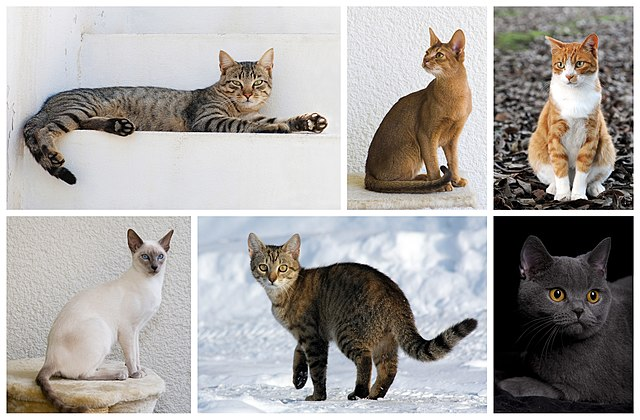

In [5]:
#filename = "wonder_cat.jpg" or "aki_dog.jpg"
#url = "https://upload.wikimedia.org/wikipedia/commons/thumb/0/0b/Cat_poster_1.jpg/640px-Cat_poster_1.jpg"
filename = input("Enter the image filename or url: ")
if filename.startswith("http"):
    filename = urllib.request.urlopen(filename)
img = Image.open(filename)

image = preprocess(img).unsqueeze(0)
image = image.to(device)
text = text.to(device)


with torch.no_grad(), torch.cuda.amp.autocast():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)


index = np.argmax(text_probs.cpu().numpy())
print("Label:", imagenet_labels[index])  # prints: tabby, tabby cat
# Display the loaded image on notebook.
display(img)

### Generating Text using CoCa

Load open clip model trained on [CoCa](https://arxiv.org/ba/2205.01917).

In [6]:
model, _, transform = open_clip.create_model_and_transforms(
  model_name="coca_ViT-L-14",
  pretrained="mscoco_finetuned_laion2B-s13B-b90k"
)

model.to(device)

CoCa(
  (text): TextTransformer(
    (token_embedding): Embedding(49408, 768)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_final): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (visual): VisionTransformer(
    (patchnorm_pre_ln): Identity()
    (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(1

#### Generate the text for the given image

In [7]:
im = img.convert("RGB")
im = transform(im).unsqueeze(0)
im = im.to(device)

with torch.no_grad(), torch.cuda.amp.autocast():
  generated = model.generate(im)

print(open_clip.decode(generated[0]).split("<end_of_text>")[0].replace("<start_of_text>", ""))

a series of pictures of cats sitting and standing . 
